# Data Exploration
Sample of Final work

**Author:** Ioakeim Ioakeim

In [15]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import csv
import xml.etree.cElementTree as et
from bokeh.io import show
from bokeh.io import output_notebook
from bokeh.models import LinearColorMapper
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure
output_notebook()
palette.reverse()
warnings.filterwarnings('ignore')
%matplotlib inline

Loading BokehJS ...

 **File Paths**

In [95]:
# File pathes for quick adjustment if places or directories change.
path_input = '00_data_input'
path_temp = '01_data_temp'
path_inter = '02_data_intermediate'
path_output = '03_data_output'
path_atlas = os.path.join(path_input, 'food_atlas.xls')
path_obesity = os.path.join(path_inter, 'obesity_refined_data.csv')
path_diabetes = os.path.join(path_inter, 'diabetes_refined_data.csv')
path_diabetes_description = os.path.join(path_inter, 'diabetes_refined_decription.csv')
path_state_geodata = os.path.join(path_input, 'us_state_geodata.csv')
path_counties_geodata = os.path.join(path_input, 'us_counties_geodata.csv')

# Background
Poverty and Obesity are two conditions which are thought to be related. Existing research suggests that there is a positive correlation between the two. 


In [17]:
#Possibly chapter 0-intro

# Objectives
To examine different socioeconomic factors, their impact on obesity, and the extend to which these factors influence obesity in the U.S.


# Methods
For this project, the purpose was to find a dataset which satisfies the several criteria, some of which include a reliable source, an adequate size, fine data granularity, recent and diverse data. Based on these criteria, the Food Access Research Atlas Data dataset was chosen as the main source of information. (later we faced the problem that the dataset’s granularity was still not fine enough, and that a dataset with anonymous individual data would have been a better option).


The set comes from https://www.usda.gov/, which is the U.S. department of agriculture, qualifying as a reliable (((((and accurate))))) source. The dataset used was Version 5/18/2017, which was the most recent version at the time the project was done. The data span between 2001 and 2016, with most data ranging from 2007 to 2015, making them recent enough for the purpose of this research. The data are also mostly complete, including all 3142 counties, which belong to the 50 States and District of Columbia, in most cases. U.S. territories and their (((100)))) county equivalents are excluded. (((Additionally, data on a county basis means the data are recorded within a scope which is not too wide))). 

 Due to the nature of the dataset, a geospatial analysis was the first statistical analysis that was carried out to examine obesity on the basis of geographical location. 

# Indicators
All the indicators used in this study are directly derived from their corresponding datasets. These include medical terms such as diabetes and obesity. The collection of these data is mostly from public entities.

**Obesity**:  Estimate of age-adjusted percentage of persons age 20 and older who are obese, where obesity is Body Mass Index (BMI) greater than or equal to 30 kilograms per meters squared. The data are estimates sourced from Centers for Disease Control and Prevention (CDC). CDC used data from the Behavioral Risk Factor Surveillance System (BRFSS) for 2008, 2009, and 2010 and from the U.S. Census Bureau.

In [18]:
df_source = pd.read_csv(path_obesity)

In [19]:
def get_data_range(series):
    df_description = series.describe()
    min_value = math.floor(df_description['min'])
    max_value = math.ceil(df_description['max'])
    values_list = series.tolist()
    return df_description, min_value, max_value, values_list

In [147]:
#Method for importing and reading state geodata
def read_state_geodata():
    nan = float('NaN')
    data = {}

    with open(path_state_geodata, 'r', newline='', encoding='utf8') as f:
        next(f)
        reader = csv.reader(f, delimiter=str(','), quotechar=str('"'))
        for row in reader:
            region, name, code, geometry, dummy = row
            xml = et.fromstring(geometry)
            lats = []
            lons = []
            for i, poly in enumerate(xml.findall('.//outerBoundaryIs/LinearRing/coordinates')):
                if i > 0:
                    lats.append(nan)
                    lons.append(nan)
                coords = (c.split(',')[:2] for c in poly.text.split())
                lat, lon = list(zip(*[(float(lat), float(lon)) for lon, lat in
                    coords]))
                lats.extend(lat)
                lons.extend(lon)
            
            # Fill one state entry in the data package.
            data[code] = {'name':name,'region':region,'lats':lats,'lons':lons}
    return data

In [179]:
#Method for plotting state geodata
def plot_state_map(title, value_name, series, value_limits=None):
    
    # Extract values from the series and get some data description.
    df_description, min_value, max_value, values_list = get_data_range(series)
    
    if (value_limits is not None):
        min_value = value_limits[0]
        max_value = value_limits[1]
    
    # Read the state geodata.
    states_raw = read_state_geodata()
    state_ids = sorted(states_raw)
    state_ids.remove('AK')
    state_ids.remove('HI')
    states = {}
    for state_id in state_ids:
        states[state_id] = states_raw[state_id]

    # Get the geographic coordinates.
    maxLon = -70
    state_xs = [state["lons"] for state in states.values()]
    for i in range(len(state_xs)):
        for k in range(len(state_xs[i])):
            if (state_xs[i][k] > maxLon):
                state_xs[i][k] = maxLon
        
    state_ys = [state["lats"] for state in states.values()]

    # Get the name of the states to map and set the values to plot.
    state_names = [state['name'] for state in states.values()]
    state_rates = values_list
    
    # Package the data into a dictionary needed for Bokeh.
    data = dict(x=state_xs, y=state_ys, name=state_names, rate=state_rates)
    
    color_mapper = LinearColorMapper(palette=palette, low=min_value, high=max_value)
    TOOLS = "pan,wheel_zoom,reset,hover,save"

    p = figure(
        title=title, x_axis_location=None, y_axis_location=None, plot_width=980,  plot_height=800,
        tooltips=[("Name", "@name"), (value_name, "@rate%")], tools=TOOLS)

    p.grid.grid_line_color = None
    p.hover.point_policy = "follow_mouse"
    p.patches('x', 'y', source=data,
              fill_color={'field': 'rate', 'transform': color_mapper},
              fill_alpha=0.7, line_color="white", line_width=0.5)

    show(p)

In [180]:
df_description, min_value, max_value, values_list = get_data_range(df_federal[column])
print('Lowest obesity rate (State Level): ', min_value)
print('Highest obesity rate (State Level): ',max_value)

Lowest obesity rate (State Level):  20
Highest obesity rate (State Level):  37


In [186]:
column = 'PCT_obese_adults_2013'
df_federal = df_source.groupby('state').median()
df_federal = df_federal.reset_index()
df_federal = df_federal[['state',column]]
#Remove Alaska
df_federal.drop(df_federal.index[0], inplace=True)
#Remove Hawai
df_federal.drop(df_federal.index[10], inplace=True)
plot_state_map('Obesity Adults US 2013','Obesity Rate', df_federal[column], (14,38))

In [182]:
df_description, min_value, max_value, values_list = get_data_range(df_federal[column])
print('Lowest obesity rate (State Level): ', min_value)
print('Highest obesity rate (State Level): ',max_value)

Lowest obesity rate (State Level):  20
Highest obesity rate (State Level):  37


# State level Obesity


Despite coarse granularity, there are some distinct differences between states and regions. The regions and divisions are based on the United States Census Bureau, which is widely used for data collection and analysis, and is the most commonly used classification system. The map shows that the Pacific, Mountain and New England divisions, in other words, mostly the West and Northeast regions, have the lowest obesity rates. On the other hand South Atlantic, West North Central and West South Central, East North Central as well as East South Central divisions; that is, mostly the Midwest and southern regions, have the highest obesity rates. Alabama, Mississippi and South Carolina are among the states with the highest rates of obesity. 


??????? should I just ignore Hawai and Alska ??????
Alaska 30.6
Hawai 22.3

**COUNTY LEVEL**

In [122]:
def extract_state_dataframe(df_source, state, column):
    df_state = df_source[df_source['state']==state.upper()][['county_fips','county','state',column]]
    df_state = df_state.sort_values('county')
    return df_state

In [123]:
#Method for importing and reading state geodata
def read_county_geodata():
    nan = float('NaN')
    data = {}

    with open(path_counties_geodata, 'r', newline='', encoding='utf8') as f:
        next(f)
        reader = csv.reader(f, delimiter=str(','), quotechar=str('"'))
        for row in reader:
            name, dummy, state, dummy, geometry, dummy, \
            dummy, dummy, det_name, state_id, county_id, dummy, dummy = row
            xml = et.fromstring(geometry)
            lats = []
            lons = []
            for i, poly in enumerate(xml.findall('.//outerBoundaryIs/LinearRing/coordinates')):
                if i > 0:
                    lats.append(nan)
                    lons.append(nan)
                coords = (c.split(',')[:2] for c in poly.text.split())
                lat, lon = list(zip(*[(float(lat), float(lon)) for lon, lat in
                    coords]))
                lats.extend(lat)
                lons.extend(lon)
                
            # Fill one couty entry in the data package.
            data[(int(state_id), int(county_id))] = {
                'name':name,'detailed name':det_name,'state':state,'lats':lats,'lons':lons}
    return data

In [124]:
#Method for plotting county geodata
def plot_county_map(title, state, value_name, series, value_limits=None):
    
    # Extract values from the series and get some data description.
    df_description, min_value, max_value, values_list = get_data_range(series)
    
    if (value_limits is not None):
        min_value = value_limits[0]
        max_value = value_limits[1]
    
    # Read the county geodata and filter out only the counties in the selected state.
    counties = read_county_geodata()
    counties = {code: county for code, county in counties.items() if county["state"]==state}

    # Get the geographic coordinates.
    county_xs = [county["lons"] for county in counties.values()]
    county_ys = [county["lats"] for county in counties.values()]

    # Get the name of the counties to map and set the values to plot.
    county_names = [county['name'] for county in counties.values()]
    county_rates = values_list
    
    # Package the data into a dictionary needed for Bokeh.
    data = dict(x=county_xs, y=county_ys, name=county_names, rate=county_rates)
    
    color_mapper = LinearColorMapper(palette=palette, low=min_value, high=max_value)
    TOOLS = "pan,wheel_zoom,reset,hover,save"

    p = figure(
        title=title, x_axis_location=None, y_axis_location=None, plot_width=980,  plot_height=980,
        tooltips=[("Name", "@name"), (value_name, "@rate%")], tools=TOOLS)

    p.grid.grid_line_color = None
    p.hover.point_policy = "follow_mouse"
    p.patches('x', 'y', source=data,
              fill_color={'field': 'rate', 'transform': color_mapper},
              fill_alpha=0.7, line_color="white", line_width=0.5)

    show(p)

In [136]:
column = 'PCT_obese_adults_2013'
df_ca = extract_state_dataframe(df_source, 'ca', column)

df_description, min_value, max_value, values_list = get_data_range(df_ca[column])

print('Lowest obesity rate (California): ', min_value)
print('Highest obesity rate (California): ',max_value)

Lowest obesity rate (California):  16
Highest obesity rate (California):  33


In [137]:
plot_county_map('California Obesity Rates US 2013', 'ca', 'Obesity Rate', df_ca[column], (14,38))

In [144]:
df_al = extract_state_dataframe(df_source, 'al', column)
plot_county_map('Obesity Adults US 2013', 'al', 'Obesity Rate', df_al[column], (14,38))

In [138]:
column = 'PCT_obese_adults_2013'
df_ny = extract_state_dataframe(df_source, 'ny', column)

df_description, min_value, max_value, values_list = get_data_range(df_ny[column])

print('Lowest obesity rate (New York): ', min_value)
print('Highest obesity rate (New York): ',max_value)

Lowest obesity rate (New York):  14
Highest obesity rate (New York):  34


In [139]:
plot_county_map('New York Obesity Rates US 2013', 'ny', 'Obesity Rate', df_ny[column], (14,38))

Mapping the states with a finer granularity; that is, on a county level, gives us more interesting information. The data shows that urban areas have lower obesity rates as oppose to non-urban ones. San Francisco, New York City, San Diego as well as Los Angeles to name a few, are examples of urban areas, which have low obesity rates. 

Further analysis of obesity rates was carried out in isolation. Plotting a histogram from 2008 obesity rates based on each county, shows a typical gaussian(normal) distribution:

In [29]:
# Load the health table from the food atlas data and extract the columns dealing with obesity.
df_health = pd.read_excel(path_atlas, sheet_name='HEALTH')
df_diabetes = df_health[['FIPS', 'PCT_DIABETES_ADULTS08', 'PCT_DIABETES_ADULTS13']].copy()

# Rename the columns to allow for better reading and referencing in the future.
df_diabetes.rename(columns={'FIPS':'county_fips','PCT_DIABETES_ADULTS08':'PCT_diabetes_adults_2008', \
                           'PCT_DIABETES_ADULTS13':'PCT_diabetes_adults_2013'}, inplace=True)

# Add some colums of values (average, change) derived directly from the ones that where in the atlas.
df_diabetes['PCT_diabetes_adults_average'] = round((df_diabetes['PCT_diabetes_adults_2008'] + df_diabetes['PCT_diabetes_adults_2013'])/2, 3)
df_diabetes['PCT_diabetes_adults_change'] = round(df_diabetes['PCT_diabetes_adults_2013'] - df_diabetes['PCT_diabetes_adults_2008'], 3)

**Distribution Plots**

In [30]:
def plot_distribution(title, series, lower_limit, upper_limit, bin_precision, y_limit, color):
    bins = np.linspace(lower_limit, upper_limit, ((upper_limit - lower_limit) / bin_precision) + 1)
    sns.set_color_codes()
    sns.set(font_scale=2)
    plt.subplots(figsize=(20,8))
    plt.title(title) 
    plt.xlim(lower_limit, upper_limit)
    plt.ylim(0, y_limit)
    plt.ylabel("Number of counties")
    sns.distplot(series.dropna(), bins=bins, color=color, kde=False, axlabel='Adult diabetes rate ')  

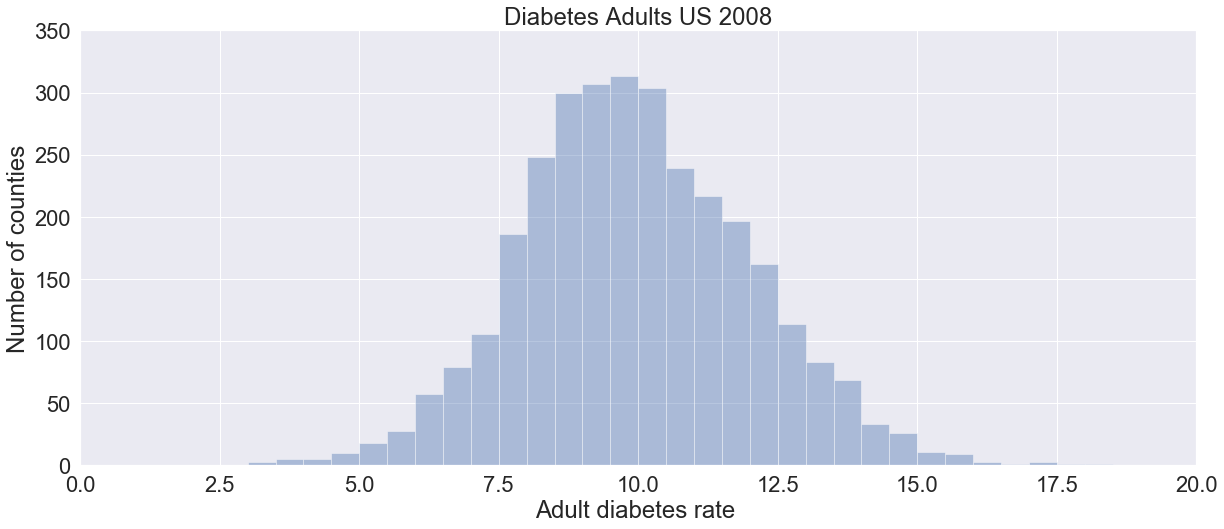

In [31]:
plot_distribution('Diabetes Adults US 2008', df_diabetes['PCT_diabetes_adults_2008'],
                  0, 20, 0.5, 350, 'b')

Similar results were observed from the data recorded in 2013:

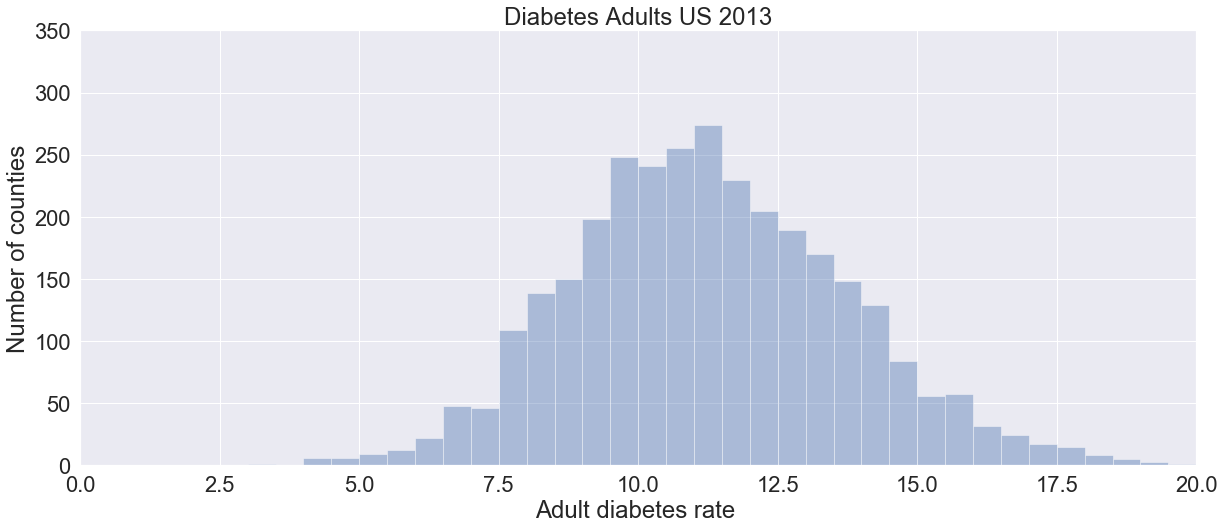

In [32]:
plot_distribution('Diabetes Adults US 2013', df_diabetes['PCT_diabetes_adults_2013'],
                  0, 20, 0.5, 350, 'b')

For more statistical information, descriptive statistics were also calculated:

In [33]:
diab_columns = ['PCT_diabetes_adults_2008','PCT_diabetes_adults_2013','PCT_diabetes_adults_average',
                'PCT_diabetes_adults_change']
df_diabetes_description = round(df_diabetes[diab_columns].describe(), 3).transpose()
df_diabetes_description.rename(index={df_diabetes_description.index[0]:'Adult diabetes rate 2008',
                                      df_diabetes_description.index[1]:'Adult diabetes rate 2013',
                                      df_diabetes_description.index[2]:'Average of adult diabetes rate from 2008 & 2013',
                                      df_diabetes_description.index[-1]:'Percentage change of adult diabetes rate from 2008 to 2013'})

,count,mean,std,min,25%,50%,75%,max
Adult diabetes rate 2008,3138.0,9.913,2.059,3.00,8.5,9.8,11.3,18.2
Adult diabetes rate 2013,3142.0,11.236,2.486,3.30,9.5,11.1,12.9,23.5
Average of adult diabetes rate from 2008 & 2013,3137.0,10.577,2.189,3.15,9.1,10.4,12.0,20.3
Percentage change of adult diabetes rate from 2008 to 2013,3137.0,1.330,1.279,-3.10,0.5,1.3,2.1,7.0


Out of all these values, the low standard deviation value of the percentage change of diabetes (last row), appears to hold some interesting information behind it. 

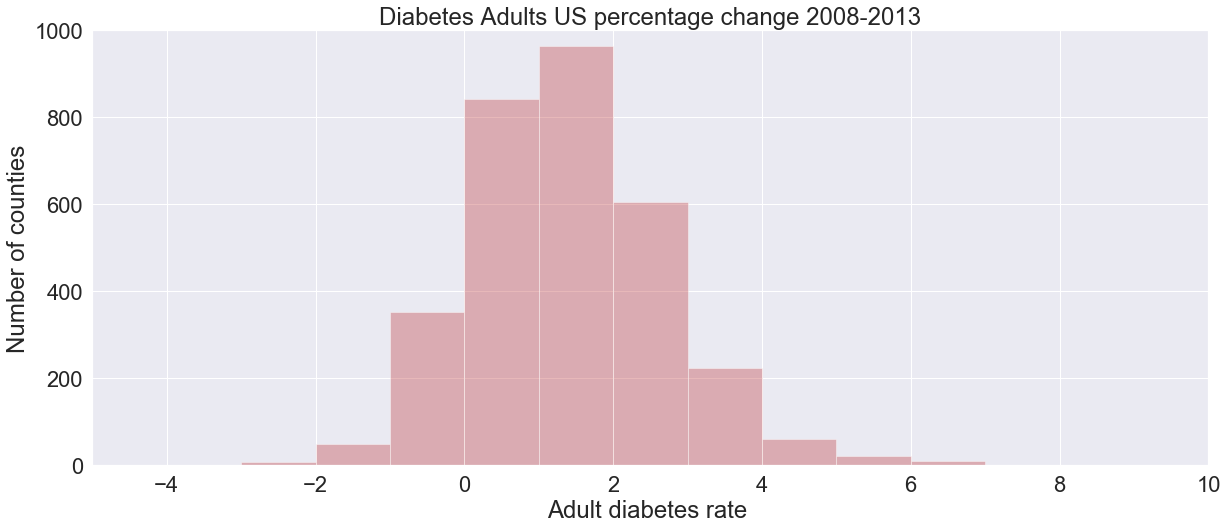

In [82]:
plot_distribution('Diabetes Adults US percentage change 2008-2013', df_diabetes['PCT_diabetes_adults_change'],
                  -5, 10, 1, 1000, 'r')

As a result, a histogram of the percentage change of diabetes from 2008 to 2013 was plotted and the findings are to be noticed. The first observation is that, diabetes rates have mostly increased between these years. The second observation is that, the percentage increase is very similar for all counties, with most of them ranging between 0% and 4%, which is what the low standard deviation value showed previously. This means the data have stability, which would justify a linear interpolation as a means of higher accuracy, in case one is required in afterwards.

For further data exploration, the variable list spreadsheet was thoroughly examined for possible factors that might corelate with obesity. As a baseline obesity rate was put up against diabetes rate, which is more of a ramification/result rather than a cause for obesity. The aim was to examine the correlations between variables that are directly related to each other and how strong these correlations are, and the aim is purely observational not analytical.

In [35]:
df_obesity = pd.read_csv(path_obesity)
df_diabetes = pd.read_csv(path_diabetes)
df_obese_diabetes = df_obesity[['county_fips','PCT_obese_adults_2013']]
df_obese_diabetes = df_obese_diabetes.merge(df_diabetes[['county_fips',
                                                         'PCT_diabetes_adults_2013']], 
                                            how='inner', on='county_fips')

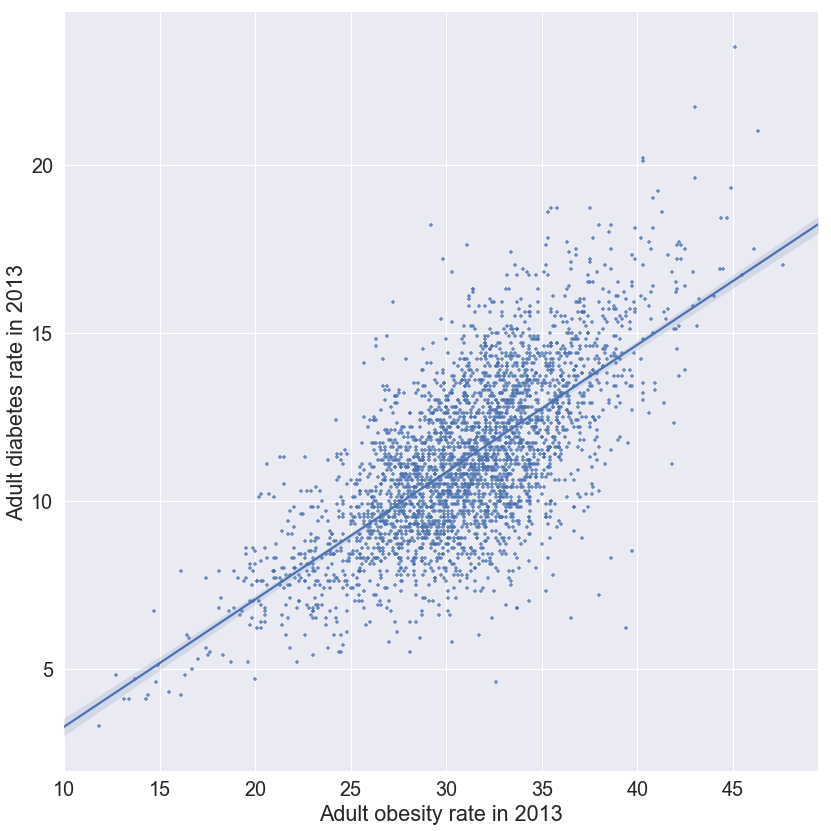

In [36]:
sns.set(font_scale=1.8)
scatter_graph = sns.lmplot(x='PCT_obese_adults_2013', y='PCT_diabetes_adults_2013', data=df_obese_diabetes, \
           size=12, markers='+', scatter_kws={"s": 10})
scatter_graph.set_axis_labels('Adult obesity rate in 2013','Adult diabetes rate in 2013')

In [37]:
#(Note to Group: Maybe skip the scatter graph to go straight to hex graph?)

The scatter graph shows a positive relationship between obesity and diabetes, but the graph does not clearly show where the data mostly lie.

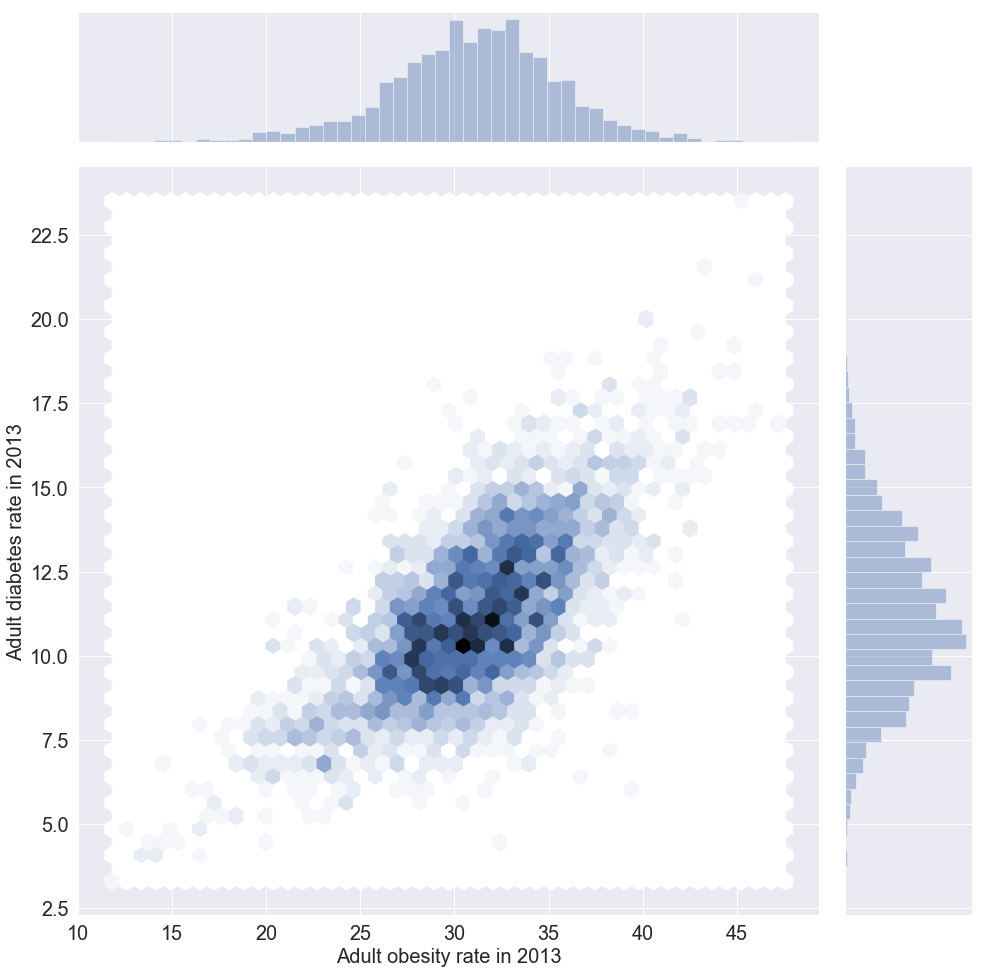

In [38]:
hex_graph = sns.jointplot(x='PCT_obese_adults_2013', y='PCT_diabetes_adults_2013', data=df_obese_diabetes,
              kind='hex', size=14)
hex_graph.set_axis_labels('Adult obesity rate in 2013','Adult diabetes rate in 2013', size = 20)

The hex graph reveals that the relationship is not as strong as one would have expected. There are multiple reasons as to why this is. Firstly, obesity is known as a main cause of type II diabetes, but not type I! Secondly there are obese people, who do not suffer from diabetes and vice versa, there are diabetics who are not obese.

In [39]:
# (Note to Group: Additional point here could be the fact 
# that the data are county based and not on an individual level, 
# which means that the linkage between obesity and diabetes between 
# individuals is missing! If this point is included, then the data 
# with individual values would have to be added here as a measure to, 
# to examine how results/data differ without this limitation).

Studies have shown that rises in obesity rates among the world population could be attributed to an increase in calorie intake coupled with lack of adequate physical activity. Fast food is regarded as a low quality, calorically dense food. For this reason, the number of fast food restaurants, and its effect on obesity was assessed. As a first step the number of empty values, in other words the number of counties with no record of the number of fast food restaurants, was calculated. The desired data, which are the records from 2014 have no empty entries.

Relevant data from the atlas were recorded in 2009 and in 2014. This gives rise to the problem that obesity and fast food data are recorded in different years. However, due to the low standard deviation value of the percentage change of obesity, as well as the assumption that realistically the number of people who are cured from obesity within one year’s time, is extremely low, the two can still be plotted against each other with relatively high accuracy.